In [2]:
import torch
import dlc_practical_prologue as prologue
import time

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
from itertools import product

In [3]:
def load_data():
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    return Variable(train_input), Variable(train_target), Variable(train_classes), Variable(test_input), Variable(test_target), Variable(test_classes)
    
train_input, train_target, train_classes, test_input, test_target, test_classes = load_data()

In [7]:
def count_parameters(model):
    nb_params = 0
    for parameter in model.parameters():
        nb_params = nb_params + parameter.numel()
    return nb_params

def accuracy(model, X, Y, mini_batch_size=100):
    
    nb_errors = 0
    
    # Proceed in batches
    for b in range(0, X.size(0), mini_batch_size):
        
        # Predict batch
        output = model(X.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        # Count errors in batch
        for k in range(mini_batch_size):
            if Y[b + k] != predicted_classes[k]:
                nb_errors = nb_errors + 1
    
    accuracy = 1 - nb_errors/X.shape[0]
    return accuracy


def train_model(model, X=train_input, Y=train_target, tX=test_input, tY=test_target,
                mini_batch_size=100, eta=1e-3, epochs=25,
                criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    start_time = time.perf_counter()
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    optimizer = opt(model.parameters(), lr=eta)
    
    for e in range(epochs):
        sum_loss = 0
        
        with torch.no_grad():
            # Compute validation loss and accuracy
            val_acc = accuracy(model, tX, tY)
            history['val_acc'].append(val_acc)

            # Compute training accuracy w/o messing with training
            train_acc = accuracy(model, X, Y)
            history['train_acc'].append(train_acc)
            
            # Compute validation loss
            val_output = model(tX)
            val_loss = criterion(val_output, tY)
            history['val_loss'].append(val_loss.item())
            
        for b in range(0, X.size(0), mini_batch_size):
            # Classify batch, compute loss and perform backpropagation with parameter updates
            output = model(X.narrow(0, b, mini_batch_size))
            loss = criterion(output, Y.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss.item()
           
        history['train_loss'].append(sum_loss)
        clear_output(wait=True)
        print('Epoch ' + str(e+1) + '/' + str(epochs))
    
    df_result = pd.DataFrame(history)
    df_result['epoch'] = range(df_result.shape[0])
    end_time = time.perf_counter()
                               
    return df_result, end_time-start_time


def cv_k_loads(model, cv=5, 
              mini_batch_size=100, eta=1e-3, epochs=25,
              criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    df_hist = pd.DataFrame(columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch'])
    
    times = []
    for i in range(cv):
        X, Y, Z, tX, tY, tZ = load_data()
        m = model()
        fold_hist, train_time = train_model(m, X, Y, tX, tY, 
                                mini_batch_size=mini_batch_size, eta=eta, epochs=epochs,
                                criterion=criterion, opt=opt)
        
        times.append(train_time)
        df_fold = pd.DataFrame(fold_hist)
        df_fold['epoch'] = range(df_fold.shape[0])
        df_fold['load'] = [i for e in range(df_fold.shape[0])]
        df_hist = pd.concat([df_hist, df_fold])
        
    return df_hist, times


def cv_k_fold(model, X=train_input, Y=train_target, tX=test_input, tY=test_input, cv=5, 
              mini_batch_size=100, eta=1e-3, epochs=25,
              criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    split_X = X.chunk(cv)
    split_Y = Y.chunk(cv)
    
    df_hist = pd.DataFrame(columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch'])
    
    times = []
    for i in range(cv):
        m = model()
        rest_X = torch.cat([f for j, f in enumerate(split_X) if j!=i])
        rest_Y = torch.cat([f for j, f in enumerate(split_Y) if j!=i])
        fold_hist, train_time = train_model(m, split_X[i], split_Y[i], rest_X, rest_Y, 
                                mini_batch_size=mini_batch_size, eta=eta, epochs=epochs,
                                criterion=criterion, opt=opt)
        
        times.append(train_time)
        df_fold = pd.DataFrame(fold_hist)
        df_fold['epoch'] = range(df_fold.shape[0])
        df_fold['fold'] = [i for e in range(df_fold.shape[0])]
        df_hist = pd.concat([df_hist, df_fold])
        
    return df_hist, times


def end_of_hist_result(df_hist):
    df_avg = df_hist.groupby('epoch').mean()
    
    # Last epoch result
    last_dict = df_avg.loc[df_avg.index.max()][['train_loss', 'train_acc', 'val_loss', 'val_acc']].to_dict()
    last_dict['epoch'] = df_avg.index.max()
    
    # Best validation accuracy result
    df_avg = df_hist.groupby('epoch').mean()
    best_dict = df_avg.loc[df_avg.val_acc.idxmax()][['train_loss', 'train_acc', 'val_loss', 'val_acc']].to_dict()
    best_dict['epoch'] = df_avg.val_acc.idxmax()
    
    return pd.concat([pd.DataFrame(last_dict, index=['last']), pd.DataFrame(best_dict, index=['best'])])


def grid_search(eval_funct, params):
    param_tuples = list(product(*params.values()))
    
    df_grid_search = pd.DataFrame(columns=['mean_train_loss', 'mean_train_acc', 'mean_val_loss', 'mean_val_acc'])
    for p in param_tuples:
        df_params = eval_funct(p)
        res = end_of_hist_result(df_params).loc['last']
        df_grid_search.loc[str(p)] = [res['train_loss'], res['train_acc'], res['val_loss'], res['val_acc']]
        
    df_grid_search['rank_val_acc'] = df_grid_search.rank(method='first')['mean_val_acc'].astype(int)
    return df_grid_search
        

def plot_hist(df_history, savefig=None):

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Loss subplot
    ax1.set_title('Evolution of cross-entropy loss over training')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.yaxis.grid(True)
    sns.lineplot(x='epoch', y='train_loss', data=df_history, label='training', ax=ax1)
    sns.lineplot(x='epoch', y='val_loss', data=df_history, label='validation', ax=ax1)
    
    # Accuracy subplot
    ax2.set_title('Evolution of classification accuracy over training')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.yaxis.grid(True)
    sns.lineplot(x='epoch', y='train_acc', data=df_history, label='training', ax=ax2)
    sns.lineplot(x='epoch', y='val_acc', data=df_history, label='validation', ax=ax2)
    
    display(end_of_hist_result(df_history))

    if savefig != None:
        plt.savefig('./results/' + savefig + '.jpg')
    plt.show()

## Round 1: comparing ConvNet with ~40k params with a similar FC architecture

### Convolutional Neural Network Architecture

In [34]:
class ConvNet1(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 256))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
conv_net_1 = ConvNet1()
print('Number of parameters of ConvNet1 : ', count_parameters(conv_net_1))

Number of parameters of ConvNet1 :  45006


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.019769,1.0,0.897100,0.8012,49
best,0.023777,1.0,0.877025,0.8016,47


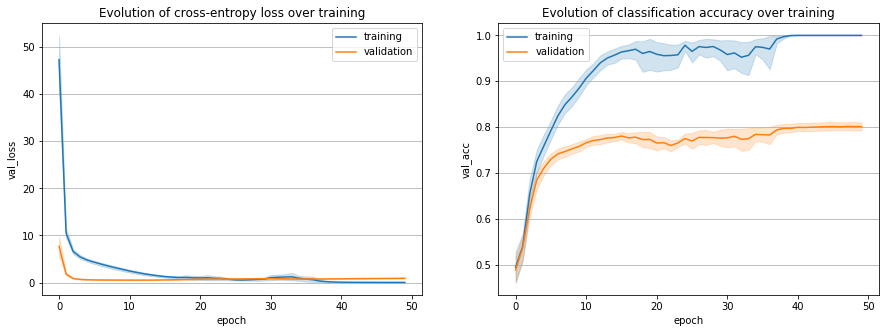

[38.345187418861315, 38.948521486949176, 31.12459699693136, 31.13803203497082, 30.542656040983275, 33.19855063292198, 38.943392901914194, 34.990695557091385, 29.474183300044388, 26.271723554003984]


In [35]:
histConvNet1, timesConvNet1 = cv_k_loads(ConvNet1, epochs=50, cv=10)

plot_hist(histConvNet1)
print(timesConvNet1)

### Fully Connected Architecture

In [36]:
class FC1(nn.Module):
    
    def __init__(self, input_size=392):
        
        super(FC1, self).__init__()
        self.fc1 = nn.Linear(input_size, 4608)
        self.fc2 = nn.Linear(4608, 1024)
        self.fc3 = nn.Linear(1024, 256) 
        self.fc4 = nn.Linear(256, 100)
        self.fc5 = nn.Linear(100, 2)
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out
    
fc_1 = FC1()
print('Number of parameters of FC1 : ', count_parameters(fc_1)) 

Number of parameters of FC1 :  6818862


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.000001,1.0,1.974369,0.8235,49
best,0.000002,1.0,1.950812,0.8235,46


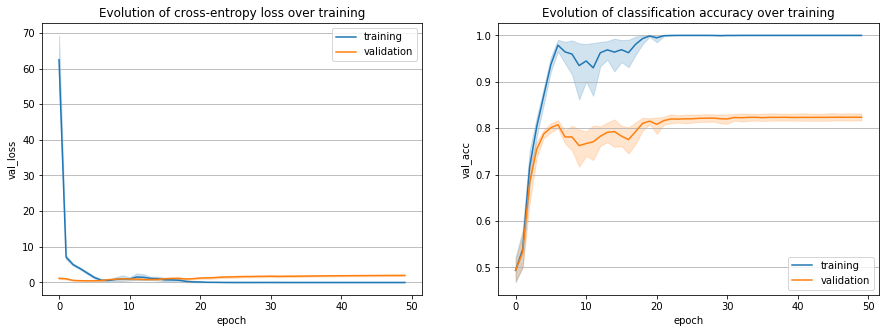

[104.56546685891226, 106.45761486608535, 105.8070502341725, 113.5521496180445, 108.37856015004218, 100.25863482104614, 108.69378002989106, 104.87234554579481, 104.01333240279928, 100.47824726719409]


In [37]:
histFC1, timesFC1 = cv_k_loads(FC1, epochs=50, cv=10)

plot_hist(histFC1)
print(timesFC1)

## Round 2: comparing ConvNet with ~140k params with a similar FC architecture

### Convolutional Neural Network Architecture

In [16]:
class ConvNet2(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)6*6*16
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 512))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    

conv_net_2 = ConvNet2()
print('Number of parameters of ConvNet2 : ', count_parameters(conv_net_2)) 

Number of parameters of ConvNet2 :  143950


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.003135,1.0,0.911491,0.8109,49
best,0.003331,1.0,0.905435,0.8111,48


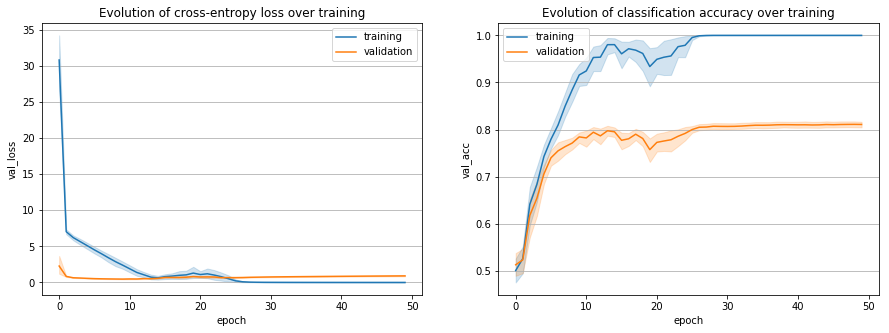

NameError: name 'timesConvNet12' is not defined

In [38]:
histConvNet2, timesConvNet2 = cv_k_loads(ConvNet2, epochs=50, cv=10)

plot_hist(histConvNet2)
print(timesConvNet2)

In [39]:
print(timesConvNet2)

[112.25441525899805, 121.03004111489281, 114.17988351196982, 117.68207631004043, 110.340610682033, 117.20403599995188, 159.0041394419968, 124.9371306039393, 121.93802483286709, 120.51730821211822]


### Fully Connected Architecture

In [40]:
class FC2(nn.Module):
    
    def __init__(self, input_size=392):
        
        super(FC2, self).__init__()
        self.fc1 = nn.Linear(input_size, 6272)
        self.fc2 = nn.Linear(6272, 9216)
        self.fc3 = nn.Linear(9216, 2048) 
        self.fc4 = nn.Linear(2048, 512)
        self.fc5 = nn.Linear(512, 100)
        self.fc6 = nn.Linear(100, 2)
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        out = F.relu(out)
        out = self.fc6(out)
        return out
    
fc_2 = FC2()
print('Number of parameters of FC2 : ', count_parameters(fc_2)) 

Number of parameters of FC2 :  80253870


Epoch 50/50


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,train_loss,train_acc,val_loss,val_acc,epoch
last,2.050400e-07,1.0,2.647952,0.819,49
best,2.497339e-04,1.0,1.741490,0.823,15


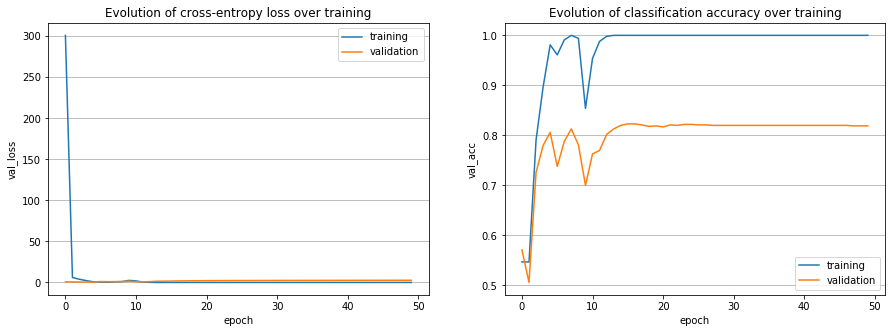

[1302.2318261140026]


In [43]:
histFC2, timesFC2 = cv_k_loads(FC2, epochs=50, cv=1)

plot_hist(histFC2)
print(timesFC2)

## Round 3: comparing ConvNet with ~70k params with a similar FC architecture

### Convolutional Neural Network Architecture

In [9]:
class ConvNet3(nn.Module):
    def __init__(self, nb_hidden=128):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4) 
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 64))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
conv_net_3 = ConvNet3()
print('Number of parameters of ConvNet3 : ', count_parameters(conv_net_3)) 

Number of parameters of ConvNet3 :  67106


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.001956,1.0,1.008114,0.8083,49
best,0.002168,1.0,0.996582,0.8085,48


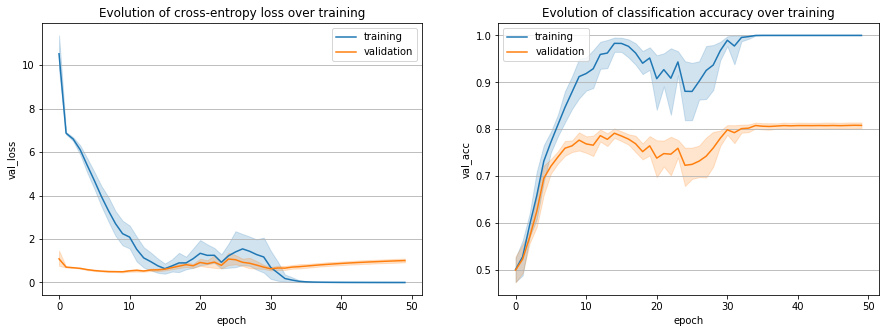

[53.027870702091604, 48.12557546491735, 47.40689961891621, 44.33607976604253, 47.867995579959825, 46.70266126585193, 50.399697113083676, 52.128598775016144, 49.96934126899578, 56.41507261386141]


In [12]:
histConvNet3, timesConvNet3 = cv_k_loads(ConvNet3, epochs=50, cv=10)

plot_hist(histConvNet3)
print(timesConvNet3)

### Fully Connected Architecture

In [13]:
class FC3(nn.Module):
    
    def __init__(self, input_size=392):
        
        super(FC3, self).__init__()
        self.fc1 = nn.Linear(input_size, 3136)
        self.fc2 = nn.Linear(3136, 2304)
        self.fc3 = nn.Linear(2304, 1152) 
        self.fc4 = nn.Linear(1152, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, 2)
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        out = F.relu(out)
        out = self.fc6(out)
        return out
    
fc_3 = FC3()
print('Number of parameters of FC3 : ', count_parameters(fc_3)) 

Number of parameters of FC3 :  11197826


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.000003,1.0,2.347383,0.8125,49
best,0.000077,1.0,2.066425,0.8134,30


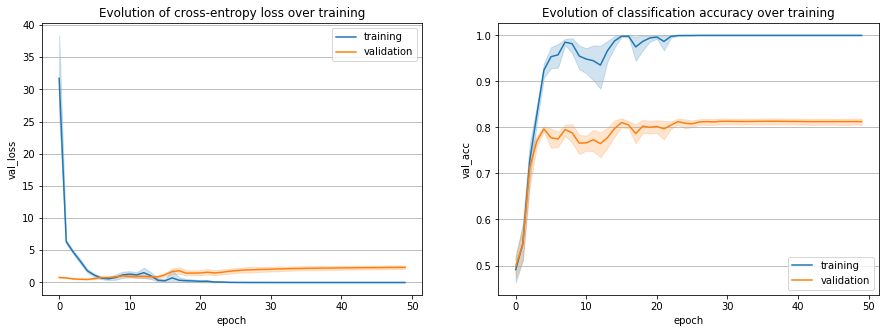

[163.7460288919974, 146.7795379590243, 156.8477907110937, 156.99222360900603, 142.86498808208853, 144.36199810518883, 150.97431580512784, 188.75624459097162, 143.66412951401435, 141.08046482899226]


In [14]:
histFC3, timesFC3 = cv_k_loads(FC3, epochs=50, cv=10)

plot_hist(histFC3)
print(timesFC3)